# Libraries

In [1]:
# Libraries
import os
import os.path as osp
import copy
import json
import pandas as pd
import numpy as np
from PIL import Image
from glob import glob

import mmcv

from mmdet.datasets.builder import DATASETS
from mmdet.datasets.custom import CustomDataset

from mmcv import Config 
from mmdet.datasets import build_dataset 
from mmdet.models import build_detector 
from mmdet.apis import train_detector 
from mmdet.datasets import (build_dataloader, build_dataset, replace_ImageToTensor)

from mmdet.apis import set_random_seed

import matplotlib.pyplot as plt
import matplotlib.patches as patches

import warnings
warnings.filterwarnings('ignore')

# Setting

In [2]:
# You can add more model configs like below.
MODELS_CONFIG = {
    'mask_rcnn': {
        'config_file': 'configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
    },
    # dir need to revise
    'detectors': {
        'config_file': 'configs/detectors/detectors_htc_r50_1x_coco.py',
    },
    'yolact': {
        'config_file': 'configs/yolact/yolact_r101_1x8_coco.py'
    }
}

In [3]:
# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'detectors'  # 'cascade_mask_rcnn_r50_fpn_1x'

# Name of the config file.
config_file = MODELS_CONFIG[selected_model]['config_file']

# Modify configuration

In [4]:
config_fname = os.path.join(config_file)

assert os.path.isfile(config_fname), '`{}` not exist'.format(config_fname)
config_fname

'configs/detectors/detectors_htc_r50_1x_coco.py'

In [5]:
dir = open("./data/train.json", "r", encoding="utf-8")
coco = json.load(dir)
print(coco["categories"])
classes_names = [category["name"] for category in coco["categories"]]
print(classes_names)

[{'id': 1, 'name': 'pet'}, {'id': 2, 'name': 'ps'}, {'id': 3, 'name': 'pp'}, {'id': 4, 'name': 'pe'}]
['pet', 'ps', 'pp', 'pe']


In [6]:
# config 파일 불러오기 
cfg = Config.fromfile(config_fname) 

print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Norm

In [7]:
# caution
# 'config/detectors_htc_r50_1x_coco.py' have to be changed to htc_without_semantic_r50_fpn_1x_coco.py 
# If not, a semantic segmentation error comes out

# config 파일 불러오기 
cfg = Config.fromfile(config_fname) 

cfg.optimizer = dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)
cfg.lr_config = dict(policy='step', warmup='linear', warmup_iters=500, warmup_ratio=0.001, step=[8, 11])
cfg.total_epochs = 7
cfg.runner.max_epochs = 7

cfg.model.roi_head.bbox_head[0].num_classes=4
cfg.model.roi_head.bbox_head[1].num_classes=4
cfg.model.roi_head.bbox_head[2].num_classes=4
cfg.model.roi_head.mask_head[0].num_classes=4
cfg.model.roi_head.mask_head[1].num_classes=4
cfg.model.roi_head.mask_head[2].num_classes=4

# Modify dataset type and path
dataset_type = 'CocoDataset'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
data_root = '/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/'
classes = ('pet', 'ps', 'pp', 'pe')

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(768, 768), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=(768, 768),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),])]

cfg.data = dict(samples_per_gpu=4,workers_per_gpu=1,
    train=dict(
        type=dataset_type,
        classes = classes,
        ann_file=data_root + 'train.json',
        img_prefix=data_root + 'train',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline))
cfg.evaluation = dict(metric=['bbox', 'segm'])

cfg.checkpoint_config = dict(interval=1)
cfg.work_dir = './log'
cfg.log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])  # dict(type='TensorboardLoggerHook')

# yapf:enable
cfg.dist_params = dict(backend='nccl')
cfg.log_level = 'INFO'
cfg.load_from = 'checkpoints/detectors_htc_r50_1x_coco-329b1453.pth'
cfg.resume_from = None
cfg.workflow = [('train', 1)]

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Norm

In [8]:
import gc
gc.collect()

# GPU 캐시 데이터 삭제 
import torch
torch.cuda.empty_cache() 

In [9]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.15s)
creating index...
index created!


2021-12-10 14:02:14,607 - mmdet - INFO - load checkpoint from local path: checkpoints/detectors_htc_r50_1x_coco-329b1453.pth


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


2021-12-10 14:02:14,982 - mmdet - WARNING - The model and loaded state dict do not match exactly

size mismatch for roi_head.bbox_head.0.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.0.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.1.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.1.fc_cls.bias: copying a param with shape torch.Size([81]) from checkpoint, the shape in current model is torch.Size([5]).
size mismatch for roi_head.bbox_head.2.fc_cls.weight: copying a param with shape torch.Size([81, 1024]) from checkpoint, the shape in current model is torch.Size([5, 1024]).
size mismatch for roi_head.bbox_head.2.fc_cls.bias: copying 

2021-12-10 14:10:51,018 - mmdet - INFO - Epoch [1][400/999]	lr: 7.982e-03, eta: 2:21:45, time: 1.344, data_time: 0.010, memory: 15190, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0006, s0.loss_cls: 0.0300, s0.acc: 99.1699, s0.loss_bbox: 0.0062, s0.loss_mask: 0.0367, s1.loss_cls: 0.0140, s1.acc: 99.4385, s1.loss_bbox: 0.0066, s1.loss_mask: 0.0195, s2.loss_cls: 0.0070, s2.acc: 99.4867, s2.loss_bbox: 0.0062, s2.loss_mask: 0.0101, loss: 0.1369
2021-12-10 14:11:57,800 - mmdet - INFO - Epoch [1][450/999]	lr: 8.981e-03, eta: 2:21:13, time: 1.336, data_time: 0.011, memory: 15190, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0006, s0.loss_cls: 0.0274, s0.acc: 99.2041, s0.loss_bbox: 0.0052, s0.loss_mask: 0.0350, s1.loss_cls: 0.0125, s1.acc: 99.3916, s1.loss_bbox: 0.0055, s1.loss_mask: 0.0186, s2.loss_cls: 0.0066, s2.acc: 99.4179, s2.loss_bbox: 0.0045, s2.loss_mask: 0.0096, loss: 0.1259
2021-12-10 14:13:06,123 - mmdet - INFO - Epoch [1][500/999]	lr: 9.980e-03, eta: 2:20:55, time: 1.366, data_time: 0.011, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 4.9 task/s, elapsed: 82s, ETA:     0s

2021-12-10 14:25:20,428 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 14:25:20,894 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.987
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.954
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.990
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.957
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.10s).


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(


Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 14:25:21,713 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1

DONE (t=0.49s).
Accumulating evaluation results...
DONE (t=0.11s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 14:26:27,776 - mmdet - INFO - Epoch [2][50/999]	lr: 1.000e-02, eta: 2:03:16, time: 1.321, data_time: 0.057, memory: 15190, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0005, s0.loss_cls: 0.0198, s0.acc: 99.2969, s0.loss_bbox: 0.0036, s0.loss_mask: 0.0371, s1.loss_cls: 0.0079, s1.acc: 99.5213, s1.loss_bbox: 0.0040, s1.loss_mask: 0.0193, s2.loss_cls: 0.0032, s2.acc: 99.6302, s2.loss_bbox: 0.0036, s2.loss_mask: 0.0098, loss: 0.1091
2021-12-10 14:27:31,669 - mmdet - INFO - Epoch [2][100/999]	lr: 1.000e-02, eta: 2:02:22, time: 1.278, data_time: 0.010, memory: 15204, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0005, s0.loss_cls: 0.0285, s0.acc: 99.2637, s0.loss_bbox: 0.004

2021-12-10 14:45:37,947 - mmdet - INFO - Epoch [2][950/999]	lr: 1.000e-02, eta: 1:45:54, time: 1.281, data_time: 0.011, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0206, s0.acc: 99.4434, s0.loss_bbox: 0.0026, s0.loss_mask: 0.0301, s1.loss_cls: 0.0099, s1.acc: 99.6054, s1.loss_bbox: 0.0031, s1.loss_mask: 0.0157, s2.loss_cls: 0.0048, s2.acc: 99.6679, s2.loss_bbox: 0.0030, s2.loss_mask: 0.0080, loss: 0.0981
2021-12-10 14:46:40,681 - mmdet - INFO - Saving checkpoint at 2 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.3 task/s, elapsed: 75s, ETA:     0s

2021-12-10 14:47:57,475 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 14:47:58,002 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.990
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.992
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.08s).
Loading and preparing results...
DONE (t=0.06s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 14:47:58,578 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.989
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.08s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 14:49:04,902 - mmdet - INFO - Epoch [3][50/999]	lr: 1.000e-02, eta: 1:41:28, time: 1.326, data_time: 0.058, memory: 15221, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0269, s0.acc: 99.3369, s0.loss_bbox: 0.0028, s0.loss_mask: 0.0490, s1.loss_cls: 0.0139, s1.acc: 99.4500, s1.loss_bbox: 0.0031, s1.loss_mask: 0.0252, s2.loss_cls: 0.0070, s2.acc: 99.4646, s2.loss_bbox: 0.0032, s2.loss_mask: 0.0128, loss: 0.1444
2021-12-10 14:50:08,467 - mmdet - INFO - Epoch [3][100/999]	lr: 1.000e-02, eta: 1:40:31, time: 1.271, data_time: 0.010, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0162, s0.acc: 99.5654, s0.loss_bbox: 0.003

2021-12-10 15:08:05,183 - mmdet - INFO - Epoch [3][950/999]	lr: 1.000e-02, eta: 1:23:44, time: 1.268, data_time: 0.011, memory: 15221, loss_rpn_cls: 0.0006, loss_rpn_bbox: 0.0004, s0.loss_cls: 0.0248, s0.acc: 99.4355, s0.loss_bbox: 0.0046, s0.loss_mask: 0.0898, s1.loss_cls: 0.0132, s1.acc: 99.5262, s1.loss_bbox: 0.0043, s1.loss_mask: 0.0462, s2.loss_cls: 0.0066, s2.acc: 99.5352, s2.loss_bbox: 0.0036, s2.loss_mask: 0.0264, loss: 0.2204
2021-12-10 15:09:07,216 - mmdet - INFO - Saving checkpoint at 3 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 4.8 task/s, elapsed: 83s, ETA:     0s

2021-12-10 15:10:31,592 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 15:10:32,160 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.46s).
Accumulating evaluation results...
DONE (t=0.10s).
Loading and preparing results...
DONE (t=0.07s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 15:10:32,811 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.988
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.45s).
Accumulating evaluation results...
DONE (t=0.10s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 15:11:37,674 - mmdet - INFO - Epoch [4][50/999]	lr: 1.000e-02, eta: 1:20:26, time: 1.297, data_time: 0.057, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0175, s0.acc: 99.4873, s0.loss_bbox: 0.0031, s0.loss_mask: 0.0354, s1.loss_cls: 0.0076, s1.acc: 99.6747, s1.loss_bbox: 0.0031, s1.loss_mask: 0.0186, s2.loss_cls: 0.0042, s2.acc: 99.7107, s2.loss_bbox: 0.0030, s2.loss_mask: 0.0089, loss: 0.1017
2021-12-10 15:12:40,915 - mmdet - INFO - Epoch [4][100/999]	lr: 1.000e-02, eta: 1:19:27, time: 1.265, data_time: 0.010, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0246, s0.acc: 99.4033, s0.loss_bbox: 0.002

2021-12-10 15:30:37,147 - mmdet - INFO - Epoch [4][950/999]	lr: 1.000e-02, eta: 1:02:35, time: 1.275, data_time: 0.011, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0202, s0.acc: 99.4961, s0.loss_bbox: 0.0025, s0.loss_mask: 0.0500, s1.loss_cls: 0.0093, s1.acc: 99.6522, s1.loss_bbox: 0.0030, s1.loss_mask: 0.0260, s2.loss_cls: 0.0047, s2.acc: 99.6794, s2.loss_bbox: 0.0029, s2.loss_mask: 0.0136, loss: 0.1325
2021-12-10 15:31:39,188 - mmdet - INFO - Saving checkpoint at 4 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.7 task/s, elapsed: 71s, ETA:     0s

2021-12-10 15:32:51,081 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 15:32:51,566 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.994
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.29s).
Accumulating evaluation results...
DONE (t=0.08s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(


DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.08s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 15:32:52,084 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1

2021-12-10 15:48:42,715 - mmdet - INFO - Epoch [5][750/999]	lr: 1.000e-02, eta: 0:45:54, time: 1.269, data_time: 0.011, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0161, s0.acc: 99.5859, s0.loss_bbox: 0.0024, s0.loss_mask: 0.0440, s1.loss_cls: 0.0082, s1.acc: 99.6659, s1.loss_bbox: 0.0027, s1.loss_mask: 0.0224, s2.loss_cls: 0.0040, s2.acc: 99.7419, s2.loss_bbox: 0.0029, s2.loss_mask: 0.0114, loss: 0.1144
2021-12-10 15:49:46,202 - mmdet - INFO - Epoch [5][800/999]	lr: 1.000e-02, eta: 0:44:53, time: 1.270, data_time: 0.011, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0276, s0.acc: 99.3525, s0.loss_bbox: 0.0025, s0.loss_mask: 0.0319, s1.loss_cls: 0.0146, s1.acc: 99.4286, s1.loss_bbox: 0.0026, s1.loss_mask: 0.0163, s2.loss_cls: 0.0076, s2.acc: 99.4393, s2.loss_bbox: 0.0029, s2.loss_mask: 0.0084, loss: 0.1147
2021-12-10 15:50:52,941 - mmdet - INFO - Epoch [5][850/999]	lr: 1.000e-02, eta: 0:43:54, time: 1.335, data_time: 0.011, me

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.6 task/s, elapsed: 71s, ETA:     0s

2021-12-10 15:55:22,343 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 15:55:22,837 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.993
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.41s).
Accumulating evaluation results...
DONE (t=0.08s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 15:55:23,354 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.36s).
Accumulating evaluation results...
DONE (t=0.08s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 15:56:30,816 - mmdet - INFO - Epoch [6][50/999]	lr: 1.000e-02, eta: 0:39:33, time: 1.349, data_time: 0.059, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0242, s0.acc: 99.4199, s0.loss_bbox: 0.0023, s0.loss_mask: 0.0291, s1.loss_cls: 0.0122, s1.acc: 99.5507, s1.loss_bbox: 0.0025, s1.loss_mask: 0.0149, s2.loss_cls: 0.0063, s2.acc: 99.5526, s2.loss_bbox: 0.0025, s2.loss_mask: 0.0076, loss: 0.1019
2021-12-10 15:57:35,728 - mmdet - INFO - Epoch [6][100/999]	lr: 1.000e-02, eta: 0:38:34, time: 1.298, data_time: 0.012, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0253, s0.acc: 99.3584, s0.loss_bbox: 0.002

2021-12-10 16:15:59,829 - mmdet - INFO - Epoch [6][950/999]	lr: 1.000e-02, eta: 0:21:29, time: 1.301, data_time: 0.012, memory: 15221, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0082, s0.acc: 99.6699, s0.loss_bbox: 0.0020, s0.loss_mask: 0.0303, s1.loss_cls: 0.0017, s1.acc: 99.8925, s1.loss_bbox: 0.0025, s1.loss_mask: 0.0155, s2.loss_cls: 0.0007, s2.acc: 99.9295, s2.loss_bbox: 0.0026, s2.loss_mask: 0.0079, loss: 0.0718
2021-12-10 16:17:03,550 - mmdet - INFO - Saving checkpoint at 6 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.7 task/s, elapsed: 70s, ETA:     0s

2021-12-10 16:18:14,651 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 16:18:15,186 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.971
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.44s).
Accumulating evaluation results...
DONE (t=0.08s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 16:18:15,728 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.39s).
Accumulating evaluation results...
DONE (t=0.07s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 16:19:21,524 - mmdet - INFO - Epoch [7][50/999]	lr: 1.000e-02, eta: 0:19:19, time: 1.315, data_time: 0.058, memory: 15228, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0003, s0.loss_cls: 0.0200, s0.acc: 99.4590, s0.loss_bbox: 0.0038, s0.loss_mask: 0.0383, s1.loss_cls: 0.0096, s1.acc: 99.5596, s1.loss_bbox: 0.0043, s1.loss_mask: 0.0201, s2.loss_cls: 0.0055, s2.acc: 99.5555, s2.loss_bbox: 0.0039, s2.loss_mask: 0.0091, loss: 0.1151
2021-12-10 16:20:26,741 - mmdet - INFO - Epoch [7][100/999]	lr: 1.000e-02, eta: 0:18:18, time: 1.304, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0202, s0.acc: 99.4844, s0.loss_bbox: 0.002

2021-12-10 16:38:53,421 - mmdet - INFO - Epoch [7][950/999]	lr: 1.000e-02, eta: 0:01:00, time: 1.354, data_time: 0.012, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0083, s0.acc: 99.7109, s0.loss_bbox: 0.0017, s0.loss_mask: 0.0299, s1.loss_cls: 0.0018, s1.acc: 99.8867, s1.loss_bbox: 0.0025, s1.loss_mask: 0.0154, s2.loss_cls: 0.0013, s2.acc: 99.9029, s2.loss_bbox: 0.0023, s2.loss_mask: 0.0074, loss: 0.0710
2021-12-10 16:39:59,395 - mmdet - INFO - Saving checkpoint at 7 epochs


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.7 task/s, elapsed: 70s, ETA:     0s

2021-12-10 16:41:10,429 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.11s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.28s).
Accumulating evaluation results...


2021-12-10 16:41:10,906 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.997
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.995
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.04s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.35s).
Accumulating evaluation results...


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 16:41:11,403 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.991
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.07s).


# Fine tuning

In [10]:
# caution
# 'config/detectors_htc_r50_1x_coco.py' have to be changed to htc_without_semantic_r50_fpn_1x_coco.py 
# If not, a semantic segmentation error comes out

# config 파일 불러오기 
cfg = Config.fromfile(config_fname) 

cfg.optimizer = dict(type='SGD', lr=0.002, momentum=0.9, weight_decay=0.0001)
cfg.optimizer_config = dict(grad_clip=None)
cfg.lr_config = dict(policy='step', warmup='linear', warmup_iters=500, warmup_ratio=0.001, step=[8, 11])
cfg.total_epochs = 12
cfg.runner.max_epochs = 12

cfg.model.roi_head.bbox_head[0].num_classes=4
cfg.model.roi_head.bbox_head[1].num_classes=4
cfg.model.roi_head.bbox_head[2].num_classes=4
cfg.model.roi_head.mask_head[0].num_classes=4
cfg.model.roi_head.mask_head[1].num_classes=4
cfg.model.roi_head.mask_head[2].num_classes=4

# Modify dataset type and path
dataset_type = 'CocoDataset'
img_norm_cfg = dict(mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
data_root = '/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/'
classes = ('pet', 'ps', 'pp', 'pe')

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(768, 768), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(type='Normalize', **img_norm_cfg),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks']),]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='MultiScaleFlipAug',
        img_scale=(768, 768),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip'),
            dict(type='Normalize', **img_norm_cfg),
            dict(type='Pad', size_divisor=32),
            dict(type='ImageToTensor', keys=['img']),
            dict(type='Collect', keys=['img']),])]

cfg.data = dict(samples_per_gpu=4,workers_per_gpu=1,
    train=dict(
        type=dataset_type,
        classes = classes,
        ann_file=data_root + 'final.json',
        img_prefix=data_root + 'final',
        pipeline=train_pipeline),
    val=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline),
    test=dict(
        type=dataset_type,
	    classes = classes,
        ann_file=data_root + 'val.json',
        img_prefix=data_root + 'test',
        pipeline=test_pipeline))
cfg.evaluation = dict(metric=['bbox', 'segm'])

cfg.checkpoint_config = dict(interval=1)
cfg.work_dir = './log'
cfg.log_config = dict(interval=50, hooks=[dict(type='TextLoggerHook')])  # dict(type='TensorboardLoggerHook')

# yapf:enable
cfg.dist_params = dict(backend='nccl')
cfg.log_level = 'INFO'
cfg.load_from = None
cfg.resume_from = 'log/epoch_7.pth'
cfg.workflow = [('train', 1)]

# Set seed thus the results are more reproducible
cfg.seed = 0
set_random_seed(0, deterministic=False)
cfg.gpu_ids = range(1)

# We can initialize the logger for training and have a look
# at the final config used for training
print(f'Config:\n{cfg.pretty_text}')

Config:
dataset_type = 'CocoDataset'
data_root = 'data/coco/'
img_norm_cfg = dict(
    mean=[123.675, 116.28, 103.53], std=[58.395, 57.12, 57.375], to_rgb=True)
train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations', with_bbox=True, with_mask=True),
    dict(type='Resize', img_scale=(1333, 800), keep_ratio=True),
    dict(type='RandomFlip', flip_ratio=0.5),
    dict(
        type='Normalize',
        mean=[123.675, 116.28, 103.53],
        std=[58.395, 57.12, 57.375],
        to_rgb=True),
    dict(type='Pad', size_divisor=32),
    dict(type='DefaultFormatBundle'),
    dict(type='Collect', keys=['img', 'gt_bboxes', 'gt_labels', 'gt_masks'])
]
test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(
        type='MultiScaleFlipAug',
        img_scale=(1333, 800),
        flip=False,
        transforms=[
            dict(type='Resize', keep_ratio=True),
            dict(type='RandomFlip', flip_ratio=0.5),
            dict(
                type='Norm

In [11]:
# Build dataset
datasets = [build_dataset(cfg.data.train)]

# Build the detector
model = build_detector(cfg.model)
# Add an attribute for visualization convenience
model.CLASSES = datasets[0].CLASSES

# Create work_dir
mmcv.mkdir_or_exist(osp.abspath(cfg.work_dir))
train_detector(model, datasets, cfg, distributed=False, validate=True)

loading annotations into memory...
Done (t=0.18s)
creating index...
index created!


2021-12-10 16:41:14,623 - mmdet - INFO - load checkpoint from local path: log/epoch_7.pth


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


2021-12-10 16:41:15,085 - mmdet - INFO - resumed epoch 7, iter 6993
2021-12-10 16:41:15,087 - mmdet - INFO - Start running, host: kerrykim@KerryKim, work_dir: /home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/log
2021-12-10 16:41:15,088 - mmdet - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) CheckpointHook                     
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) StepLrUpdaterHook                  
(NORMAL      ) NumClassCheckHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook                           
(VERY_LOW    ) TextLoggerHook                     
 -------------------- 
before_train_iter:
(VERY_HIGH   ) StepLrUpdaterHook                  
(LOW         ) IterTimerHook                      
(LOW         ) EvalHook  

2021-12-10 16:56:11,471 - mmdet - INFO - Epoch [8][700/1099]	lr: 1.000e-02, eta: 1:57:16, time: 1.278, data_time: 0.010, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0153, s0.acc: 99.5732, s0.loss_bbox: 0.0017, s0.loss_mask: 0.0283, s1.loss_cls: 0.0076, s1.acc: 99.6875, s1.loss_bbox: 0.0021, s1.loss_mask: 0.0145, s2.loss_cls: 0.0036, s2.acc: 99.7314, s2.loss_bbox: 0.0023, s2.loss_mask: 0.0074, loss: 0.0832
2021-12-10 16:57:16,109 - mmdet - INFO - Epoch [8][750/1099]	lr: 1.000e-02, eta: 1:56:16, time: 1.293, data_time: 0.010, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0169, s0.acc: 99.5381, s0.loss_bbox: 0.0016, s0.loss_mask: 0.0289, s1.loss_cls: 0.0080, s1.acc: 99.6826, s1.loss_bbox: 0.0019, s1.loss_mask: 0.0148, s2.loss_cls: 0.0045, s2.acc: 99.6816, s2.loss_bbox: 0.0021, s2.loss_mask: 0.0076, loss: 0.0866
2021-12-10 16:58:20,458 - mmdet - INFO - Epoch [8][800/1099]	lr: 1.000e-02, eta: 1:55:14, time: 1.287, data_time: 0.010,

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.6 task/s, elapsed: 71s, ETA:     0s

2021-12-10 17:05:57,283 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 17:05:57,666 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.994
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.30s).
Accumulating evaluation results...
DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 17:05:58,249 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.43s).
Accumulating evaluation results...
DONE (t=0.07s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 17:07:05,525 - mmdet - INFO - Epoch [9][50/1099]	lr: 1.000e-03, eta: 1:43:29, time: 1.345, data_time: 0.058, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0264, s0.acc: 99.3818, s0.loss_bbox: 0.0013, s0.loss_mask: 0.0264, s1.loss_cls: 0.0135, s1.acc: 99.4473, s1.loss_bbox: 0.0018, s1.loss_mask: 0.0133, s2.loss_cls: 0.0071, s2.acc: 99.4159, s2.loss_bbox: 0.0020, s2.loss_mask: 0.0067, loss: 0.0988
2021-12-10 17:08:09,619 - mmdet - INFO - Epoch [9][100/1099]	lr: 1.000e-03, eta: 1:42:38, time: 1.282, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0159, s0.acc: 99.6250, s0.loss_bbox: 0.0

2021-12-10 17:26:24,835 - mmdet - INFO - Epoch [9][950/1099]	lr: 1.000e-03, eta: 1:26:46, time: 1.295, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0086, s0.acc: 99.7275, s0.loss_bbox: 0.0011, s0.loss_mask: 0.0328, s1.loss_cls: 0.0028, s1.acc: 99.8808, s1.loss_bbox: 0.0016, s1.loss_mask: 0.0167, s2.loss_cls: 0.0013, s2.acc: 99.9058, s2.loss_bbox: 0.0018, s2.loss_mask: 0.0086, loss: 0.0754
2021-12-10 17:27:29,030 - mmdet - INFO - Epoch [9][1000/1099]	lr: 1.000e-03, eta: 1:25:46, time: 1.284, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0071, s0.acc: 99.7646, s0.loss_bbox: 0.0010, s0.loss_mask: 0.0269, s1.loss_cls: 0.0019, s1.acc: 99.9072, s1.loss_bbox: 0.0015, s1.loss_mask: 0.0138, s2.loss_cls: 0.0009, s2.acc: 99.9041, s2.loss_bbox: 0.0017, s2.loss_mask: 0.0070, loss: 0.0620
2021-12-10 17:28:33,335 - mmdet - INFO - Epoch [9][1050/1099]	lr: 1.000e-03, eta: 1:24:46, time: 1.286, data_time: 0.01

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.8 task/s, elapsed: 69s, ETA:     0s

2021-12-10 17:30:46,801 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 17:30:47,166 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.995
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 17:30:47,655 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.07s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 17:31:54,232 - mmdet - INFO - Epoch [10][50/1099]	lr: 1.000e-03, eta: 1:21:00, time: 1.331, data_time: 0.059, memory: 15228, loss_rpn_cls: 0.0000, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0112, s0.acc: 99.6836, s0.loss_bbox: 0.0012, s0.loss_mask: 0.0439, s1.loss_cls: 0.0049, s1.acc: 99.7734, s1.loss_bbox: 0.0016, s1.loss_mask: 0.0230, s2.loss_cls: 0.0026, s2.acc: 99.7949, s2.loss_bbox: 0.0018, s2.loss_mask: 0.0116, loss: 0.1019
2021-12-10 17:32:57,770 - mmdet - INFO - Epoch [10][100/1099]	lr: 1.000e-03, eta: 1:20:02, time: 1.271, data_time: 0.012, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0129, s0.acc: 99.6875, s0.loss_bbox: 0

2021-12-10 17:50:47,410 - mmdet - INFO - Epoch [10][950/1099]	lr: 1.000e-03, eta: 1:02:56, time: 1.240, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0146, s0.acc: 99.6172, s0.loss_bbox: 0.0010, s0.loss_mask: 0.0280, s1.loss_cls: 0.0073, s1.acc: 99.6699, s1.loss_bbox: 0.0015, s1.loss_mask: 0.0144, s2.loss_cls: 0.0038, s2.acc: 99.6846, s2.loss_bbox: 0.0018, s2.loss_mask: 0.0073, loss: 0.0799
2021-12-10 17:51:49,350 - mmdet - INFO - Epoch [10][1000/1099]	lr: 1.000e-03, eta: 1:01:54, time: 1.239, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0153, s0.acc: 99.6035, s0.loss_bbox: 0.0011, s0.loss_mask: 0.0283, s1.loss_cls: 0.0075, s1.acc: 99.6699, s1.loss_bbox: 0.0017, s1.loss_mask: 0.0144, s2.loss_cls: 0.0038, s2.acc: 99.6912, s2.loss_bbox: 0.0018, s2.loss_mask: 0.0073, loss: 0.0814
2021-12-10 17:52:50,672 - mmdet - INFO - Epoch [10][1050/1099]	lr: 1.000e-03, eta: 1:00:51, time: 1.226, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.9 task/s, elapsed: 68s, ETA:     0s

2021-12-10 17:55:00,804 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 17:55:01,278 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.998
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.996
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.28s).
Accumulating evaluation results...
DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 17:55:01,769 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.07s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 17:56:05,524 - mmdet - INFO - Epoch [11][50/1099]	lr: 1.000e-03, eta: 0:57:58, time: 1.275, data_time: 0.059, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0104, s0.acc: 99.7002, s0.loss_bbox: 0.0012, s0.loss_mask: 0.0307, s1.loss_cls: 0.0039, s1.acc: 99.8037, s1.loss_bbox: 0.0019, s1.loss_mask: 0.0159, s2.loss_cls: 0.0023, s2.acc: 99.7830, s2.loss_bbox: 0.0017, s2.loss_mask: 0.0075, loss: 0.0758
2021-12-10 17:57:07,323 - mmdet - INFO - Epoch [11][100/1099]	lr: 1.000e-03, eta: 0:56:58, time: 1.236, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0153, s0.acc: 99.5967, s0.loss_bbox: 0

2021-12-10 18:14:40,847 - mmdet - INFO - Epoch [11][950/1099]	lr: 1.000e-03, eta: 0:39:46, time: 1.236, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0075, s0.acc: 99.7744, s0.loss_bbox: 0.0014, s0.loss_mask: 0.0312, s1.loss_cls: 0.0020, s1.acc: 99.9062, s1.loss_bbox: 0.0021, s1.loss_mask: 0.0159, s2.loss_cls: 0.0011, s2.acc: 99.9159, s2.loss_bbox: 0.0018, s2.loss_mask: 0.0075, loss: 0.0706
2021-12-10 18:15:42,736 - mmdet - INFO - Epoch [11][1000/1099]	lr: 1.000e-03, eta: 0:38:45, time: 1.238, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0002, loss_rpn_bbox: 0.0002, s0.loss_cls: 0.0110, s0.acc: 99.7412, s0.loss_bbox: 0.0024, s0.loss_mask: 0.0428, s1.loss_cls: 0.0044, s1.acc: 99.8310, s1.loss_bbox: 0.0028, s1.loss_mask: 0.0177, s2.loss_cls: 0.0024, s2.acc: 99.8505, s2.loss_bbox: 0.0027, s2.loss_mask: 0.0083, loss: 0.0948
2021-12-10 18:16:44,146 - mmdet - INFO - Epoch [11][1050/1099]	lr: 1.000e-03, eta: 0:37:44, time: 1.228, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.9 task/s, elapsed: 68s, ETA:     0s

2021-12-10 18:18:54,366 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.12s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.29s).
Accumulating evaluation results...


2021-12-10 18:18:54,856 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.998
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*
DONE (t=0.35s).
Accumulating evaluation results...


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 18:18:55,353 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.992
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.07s).


/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/mmcv/runner/hooks/logger/text.py:112: DeprecationWarning: an integer is required (got type float).  Implicit conversion to integers using __int__ is deprecated, and may be removed in a future version of Python.
  mem_mb = torch.tensor([mem / (1024 * 1024)],
2021-12-10 18:19:58,822 - mmdet - INFO - Epoch [12][50/1099]	lr: 1.000e-04, eta: 0:35:20, time: 1.269, data_time: 0.058, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0140, s0.acc: 99.6416, s0.loss_bbox: 0.0017, s0.loss_mask: 0.0319, s1.loss_cls: 0.0067, s1.acc: 99.6904, s1.loss_bbox: 0.0016, s1.loss_mask: 0.0147, s2.loss_cls: 0.0036, s2.acc: 99.6825, s2.loss_bbox: 0.0017, s2.loss_mask: 0.0074, loss: 0.0836
2021-12-10 18:21:00,463 - mmdet - INFO - Epoch [12][100/1099]	lr: 1.000e-04, eta: 0:34:20, time: 1.233, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0151, s0.acc: 99.6299, s0.loss_bbox: 0

2021-12-10 18:38:27,201 - mmdet - INFO - Epoch [12][950/1099]	lr: 1.000e-04, eta: 0:17:12, time: 1.231, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0003, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0126, s0.acc: 99.6768, s0.loss_bbox: 0.0013, s0.loss_mask: 0.0306, s1.loss_cls: 0.0056, s1.acc: 99.7637, s1.loss_bbox: 0.0020, s1.loss_mask: 0.0156, s2.loss_cls: 0.0032, s2.acc: 99.7492, s2.loss_bbox: 0.0019, s2.loss_mask: 0.0075, loss: 0.0807
2021-12-10 18:39:28,601 - mmdet - INFO - Epoch [12][1000/1099]	lr: 1.000e-04, eta: 0:16:11, time: 1.228, data_time: 0.011, memory: 15228, loss_rpn_cls: 0.0001, loss_rpn_bbox: 0.0001, s0.loss_cls: 0.0086, s0.acc: 99.7666, s0.loss_bbox: 0.0009, s0.loss_mask: 0.0271, s1.loss_cls: 0.0037, s1.acc: 99.8408, s1.loss_bbox: 0.0014, s1.loss_mask: 0.0138, s2.loss_cls: 0.0018, s2.acc: 99.8661, s2.loss_bbox: 0.0016, s2.loss_mask: 0.0070, loss: 0.0662
2021-12-10 18:40:30,036 - mmdet - INFO - Epoch [12][1050/1099]	lr: 1.000e-04, eta: 0:15:10, time: 1.229, data_time: 0

[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 400/400, 5.9 task/s, elapsed: 67s, ETA:     0s

2021-12-10 18:42:39,343 - mmdet - INFO - Evaluating bbox...


Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*


2021-12-10 18:42:39,825 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.996
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=1000 ] = 0.998
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=1000 ] = 0.999
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=300 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=1000 ] = 0.997
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=1000 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=1000 ] = 0.986
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=1000

DONE (t=0.40s).
Accumulating evaluation results...
DONE (t=0.07s).
Loading and preparing results...
DONE (t=0.05s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *segm*


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/coco.py:437: UserWarning: The key "bbox" is deleted for more accurate mask AP of small/medium/large instances since v2.12.0. This does not change the overall mAP calculation.
  warnings.warn(
/home/kerrykim/anaconda3/envs/seg_p3.9/lib/python3.9/site-packages/pycocotools-2.0.3-py3.9-linux-x86_64.egg/pycocotools/cocoeval.py:378: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  tp_sum = np.cumsum(tps, axis=1).astype(dtype=np.float)
2021-12-10 18:42:40,324 - mmdet - INFO - 
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.993
 Average Precision  (AP) @[ IoU=0.50 

DONE (t=0.35s).
Accumulating evaluation results...
DONE (t=0.07s).


/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/mmdet/datasets/utils.py:65: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


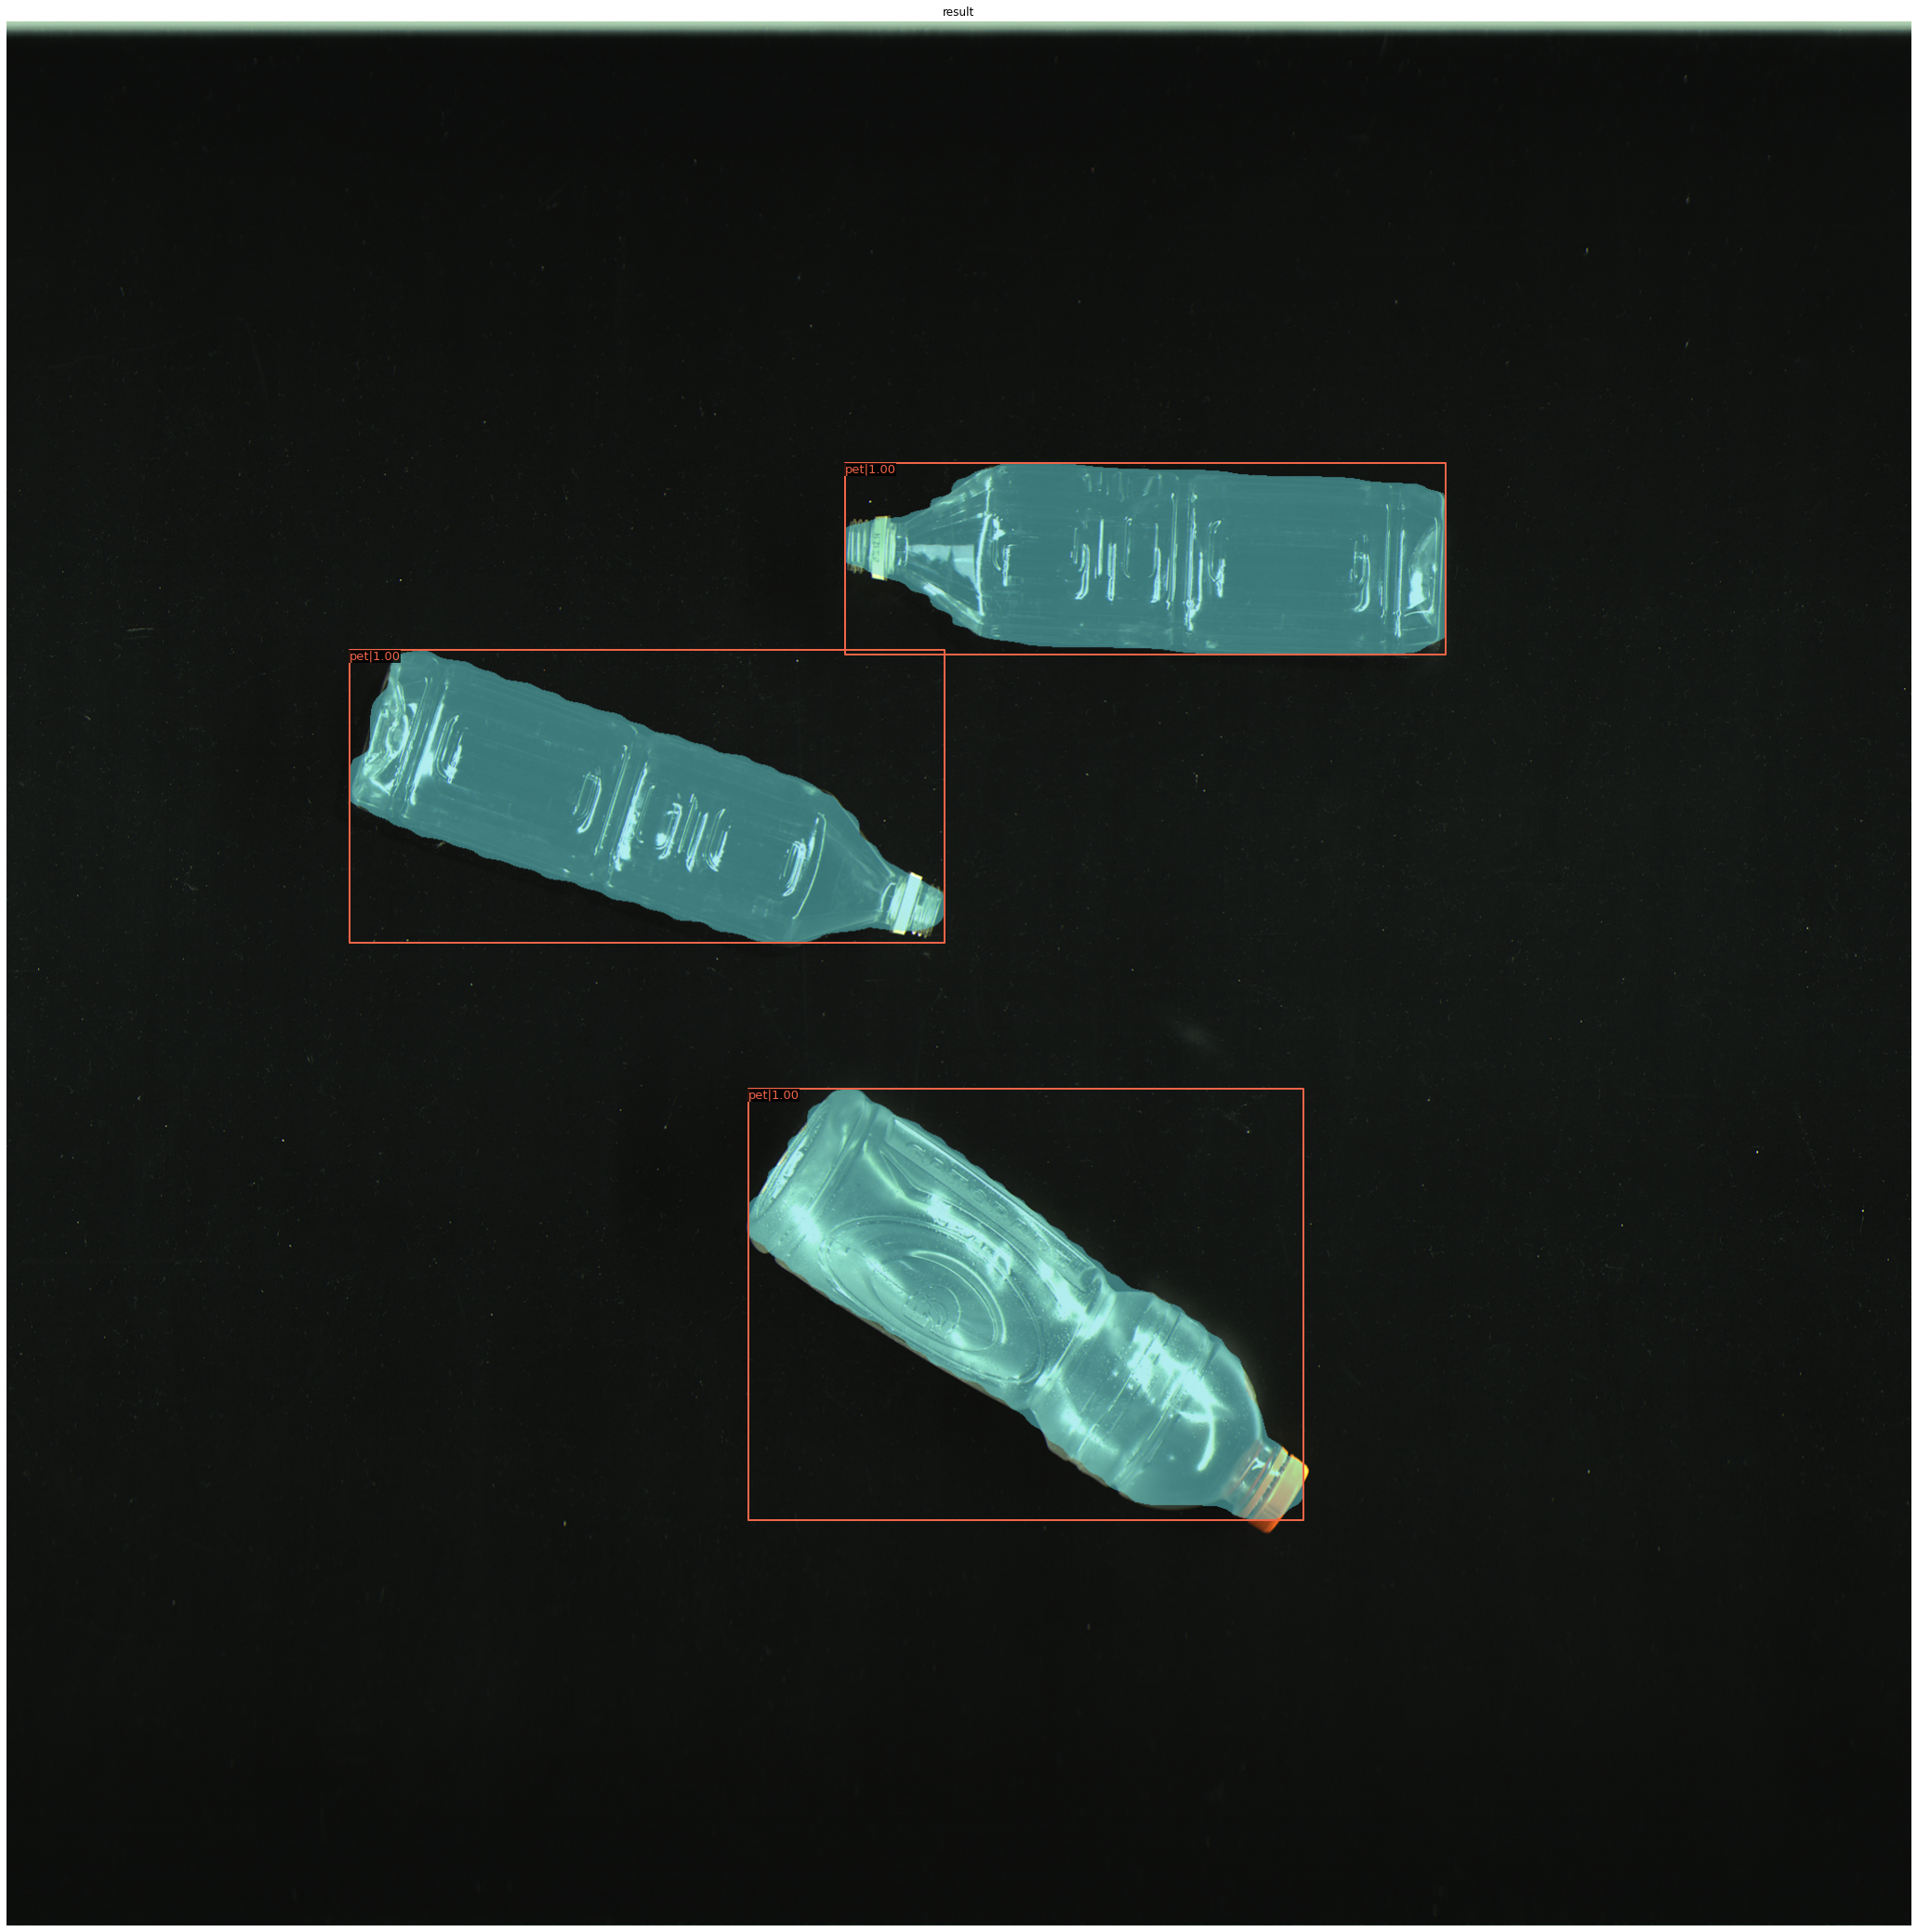

In [12]:
from mmdet.apis import inference_detector, init_detector, show_result_pyplot

img = mmcv.imread('/home/kerrykim/PycharmProjects/6.plastic_segmentation/mmdetection/data/test/PET_002_1241.jpg')

model.cfg = cfg
# model = init_detector(config_file, checkpoint_file, device=device)

result = inference_detector(model, img)
show_result_pyplot(model, img, result)